In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/301 Project
%ls

/content/drive/MyDrive/301 Project
 bonnie/
 ferg_baseline.ipynb
 FERG_DB_256/
 FERG_DB_256_reduced/
 ferg_resNet50.ipynb
 freg_GoogleNet.ipynb
 freg.ipynb
 GoogleNet.ipynb
'Group 19 (Tracy Zhang, Katelyn Wang) Emotion Classification of Animated Characters.gslides'
 mangaFacialExpression/
 manga_ResNet50.ipynb
 manga_train_from_scratch.ipynb
 result.gsheet
 tom_and_jerry/


In [3]:
import tensorflow as tf 
import numpy as np
import os
import matplotlib.pyplot as plt 

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

rawdir = listdir_nohidden('/content/drive/MyDrive/301 Project/mangaFacialExpression')
Name = sorted(rawdir)
n = len(Name)
N = list(range(n))
string_to_num_mapping = dict(zip(Name,N)) 
num_to_string_mapping = dict(zip(N,Name)) 
string_to_num_mapping

{'angry': 0,
 'crying': 1,
 'embarrassed': 2,
 'happy': 3,
 'pleased': 4,
 'sad': 5,
 'shock': 6}

In [4]:
string_to_num_mapping

{'angry': 0,
 'crying': 1,
 'embarrassed': 2,
 'happy': 3,
 'pleased': 4,
 'sad': 5,
 'shock': 6}

In [5]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.5,1),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2
)

root_dir = '/content/drive/MyDrive/301 Project/mangaFacialExpression'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")


Found 366 images belonging to 7 classes.
Found 89 images belonging to 7 classes.


In [6]:
imgs, labels = next(iter(img_generator_flow_train))
count = 0
for img, label in zip(imgs, labels):
  value=np.argmax(label)
  plt.imshow(img)
  plt.title(num_to_string_mapping[value])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## GoogleNet Model

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [8]:
class Inception(tf.keras.Model):
    #c1 ~ c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

In [16]:
model = tf.keras.models.Sequential()
#b1
#model.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
model.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model.add(Inception(64, (96, 128), (16, 32), 32))
model.add(Inception(128, (128, 192), (32, 96), 64))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model.add(Inception(192, (96, 208), (16, 48), 64))
model.add(Inception(160, (112, 224), (24, 64), 64))
model.add(Inception(128, (128, 256), (24, 64), 64))
model.add(Inception(112, (144, 288), (32, 64), 64))
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b5
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(Inception(384, (192, 384), (48, 128), 128))
model.add(layers.GlobalAvgPool2D())
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())

#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))


In [17]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 conv2d_59 (Conv2D)          (None, 56, 56, 192)       110784    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 192)      0         
 g2D)                                                            
                                                                 
 inception_9 (Inception)     (None, 28, 28, 256)      

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [20]:
history = model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 


Epoch 1/100
12/12 [==============================] - 4s 313ms/step - loss: 1.9359 - categorical_accuracy: 0.2104 - val_loss: 1.9126 - val_categorical_accuracy: 0.2247
Epoch 2/100
12/12 [==============================] - 3s 238ms/step - loss: 1.9184 - categorical_accuracy: 0.2240 - val_loss: 1.9041 - val_categorical_accuracy: 0.2247
Epoch 3/100
12/12 [==============================] - 3s 232ms/step - loss: 1.9076 - categorical_accuracy: 0.2213 - val_loss: 1.8938 - val_categorical_accuracy: 0.2247
Epoch 4/100
12/12 [==============================] - 3s 242ms/step - loss: 1.9053 - categorical_accuracy: 0.2213 - val_loss: 1.8919 - val_categorical_accuracy: 0.2247
Epoch 5/100
12/12 [==============================] - 3s 229ms/step - loss: 1.9133 - categorical_accuracy: 0.2240 - val_loss: 1.9148 - val_categorical_accuracy: 0.2247
Epoch 6/100
12/12 [==============================] - 3s 231ms/step - loss: 1.9115 - categorical_accuracy: 0.2240 - val_loss: 1.8915 - val_categorical_accuracy: 0.224

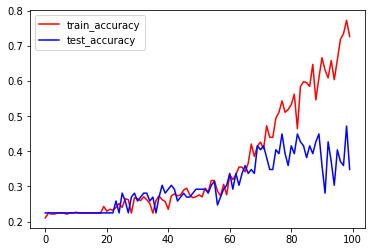

In [21]:
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [24]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

0.30528089791536334

In [25]:
max(history.history["val_categorical_accuracy"])

0.47191011905670166

In [26]:
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

LABEL = []
for item in labels:
    LABEL += [np.argmax(item)]
print(LABEL)

PRED = pred_labels.numpy().tolist()

from sklearn.metrics import classification_report
print(classification_report(LABEL, PRED))

1/1 [==============================] - 1s 511ms/step
[6, 6, 2, 1, 5, 5, 0, 2, 6, 6, 5, 5, 0, 3, 2, 2, 4, 6, 1, 4, 2, 0, 6, 6, 3, 5, 6, 2, 5, 6, 5, 3]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.40      1.00      0.57         2
           2       1.00      0.83      0.91         6
           3       0.67      0.67      0.67         3
           4       0.67      1.00      0.80         2
           5       1.00      0.57      0.73         7
           6       0.89      0.89      0.89         9

    accuracy                           0.81        32
   macro avg       0.80      0.85      0.79        32
weighted avg       0.88      0.81      0.82        32



In [27]:
x,y = img_generator_flow_valid.next()
preds = model.predict(x)
idx = np.argmax(preds, axis = 1)
y_idx = np.argmax(y, axis = 1)

1/1 [==============================] - 0s 43ms/step


In [28]:
emotion_dict = img_generator_flow_train.class_indices

In [29]:
emotion_dict

{'angry': 0,
 'crying': 1,
 'embarrassed': 2,
 'happy': 3,
 'pleased': 4,
 'sad': 5,
 'shock': 6}

In [30]:
y_idx[0]

6

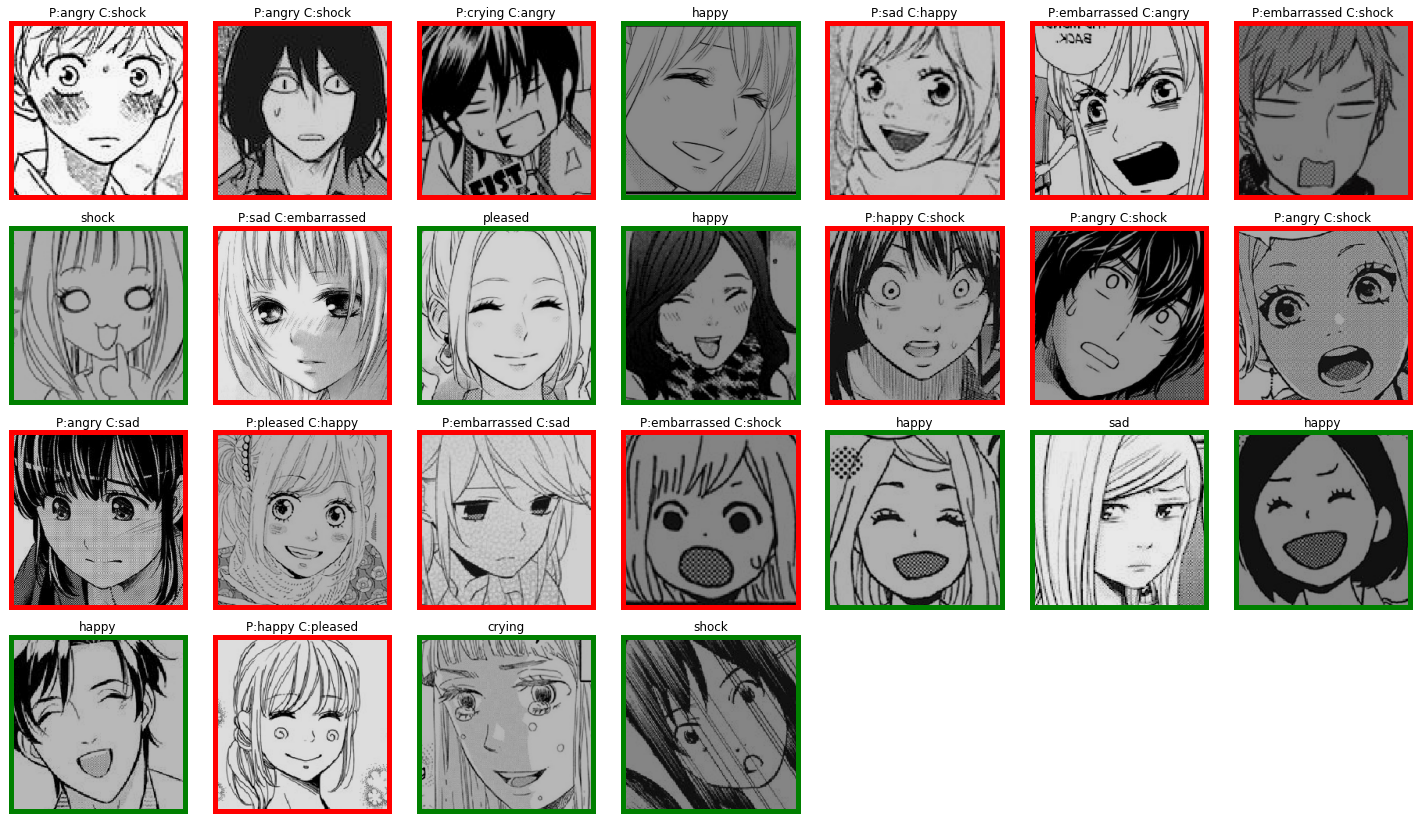

In [31]:
fig = plt.figure(1, (20, 20))

k = 0
for j in range(25):
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    index = max(y[j])
    if  y_idx[j] == idx[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')
            ans  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx[j])]
        ax.set_title(ans)

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')
            correct  = list(emotion_dict.keys())[list(emotion_dict.values()).index(y_idx[j])]
            preds  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx[j])]
        ax.set_title('P:'+preds+" C:"+correct)
    plt.tight_layout()

## Add Batch Normalization

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout

In [38]:
model2 = tf.keras.models.Sequential()

#b1
#model.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model2.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
#model2.add(layers.LeakyReLU())
model2.add(BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model2.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
model2.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'))
#model2.add(layers.LeakyReLU())
model2.add(BatchNormalization())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model2.add(Inception(64, (96, 128), (16, 32), 32))
model2.add(Inception(128, (128, 192), (32, 96), 64))
#model2.add(layers.LeakyReLU())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model2.add(Inception(192, (96, 208), (16, 48), 64))
model2.add(Inception(160, (112, 224), (24, 64), 64))
model2.add(Inception(128, (128, 256), (24, 64), 64))
model2.add(Inception(112, (144, 288), (32, 64), 64))
model2.add(Inception(256, (160, 320), (32, 128), 128))
#model2.add(layers.LeakyReLU())
model2.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b5
model2.add(Inception(256, (160, 320), (32, 128), 128))
model2.add(Inception(384, (192, 384), (48, 128), 128))
#model2.add(layers.LeakyReLU())
model2.add(layers.GlobalAvgPool2D())
model2.add(layers.Flatten())

#model.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(7, activation='softmax'))


In [39]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [40]:
img_generator_flow_train.reset()
history = model2.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 


Epoch 1/100
12/12 [==============================] - 7s 305ms/step - loss: 2.1856 - categorical_accuracy: 0.1940 - val_loss: 1.9373 - val_categorical_accuracy: 0.1910
Epoch 2/100
12/12 [==============================] - 3s 230ms/step - loss: 1.9189 - categorical_accuracy: 0.2240 - val_loss: 1.9176 - val_categorical_accuracy: 0.2247
Epoch 3/100
12/12 [==============================] - 3s 228ms/step - loss: 1.9064 - categorical_accuracy: 0.2240 - val_loss: 1.9162 - val_categorical_accuracy: 0.2247
Epoch 4/100
12/12 [==============================] - 3s 227ms/step - loss: 1.8884 - categorical_accuracy: 0.2240 - val_loss: 1.9234 - val_categorical_accuracy: 0.1910
Epoch 5/100
12/12 [==============================] - 3s 227ms/step - loss: 1.8938 - categorical_accuracy: 0.2377 - val_loss: 1.9254 - val_categorical_accuracy: 0.1910
Epoch 6/100
12/12 [==============================] - 3s 231ms/step - loss: 1.8952 - categorical_accuracy: 0.2186 - val_loss: 1.9199 - val_categorical_accuracy: 0.191

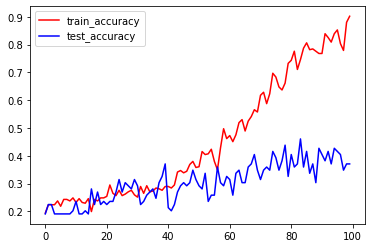

In [41]:
plt.plot(model2.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model2.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

In [43]:
max(history.history["val_categorical_accuracy"])

0.4606741666793823

In [44]:
x2,y2 = img_generator_flow_valid.next()
preds2 = model2.predict(x2)
idx2 = np.argmax(preds2, axis = 1)
y_idx2 = np.argmax(y2, axis = 1)

1/1 [==============================] - 1s 511ms/step


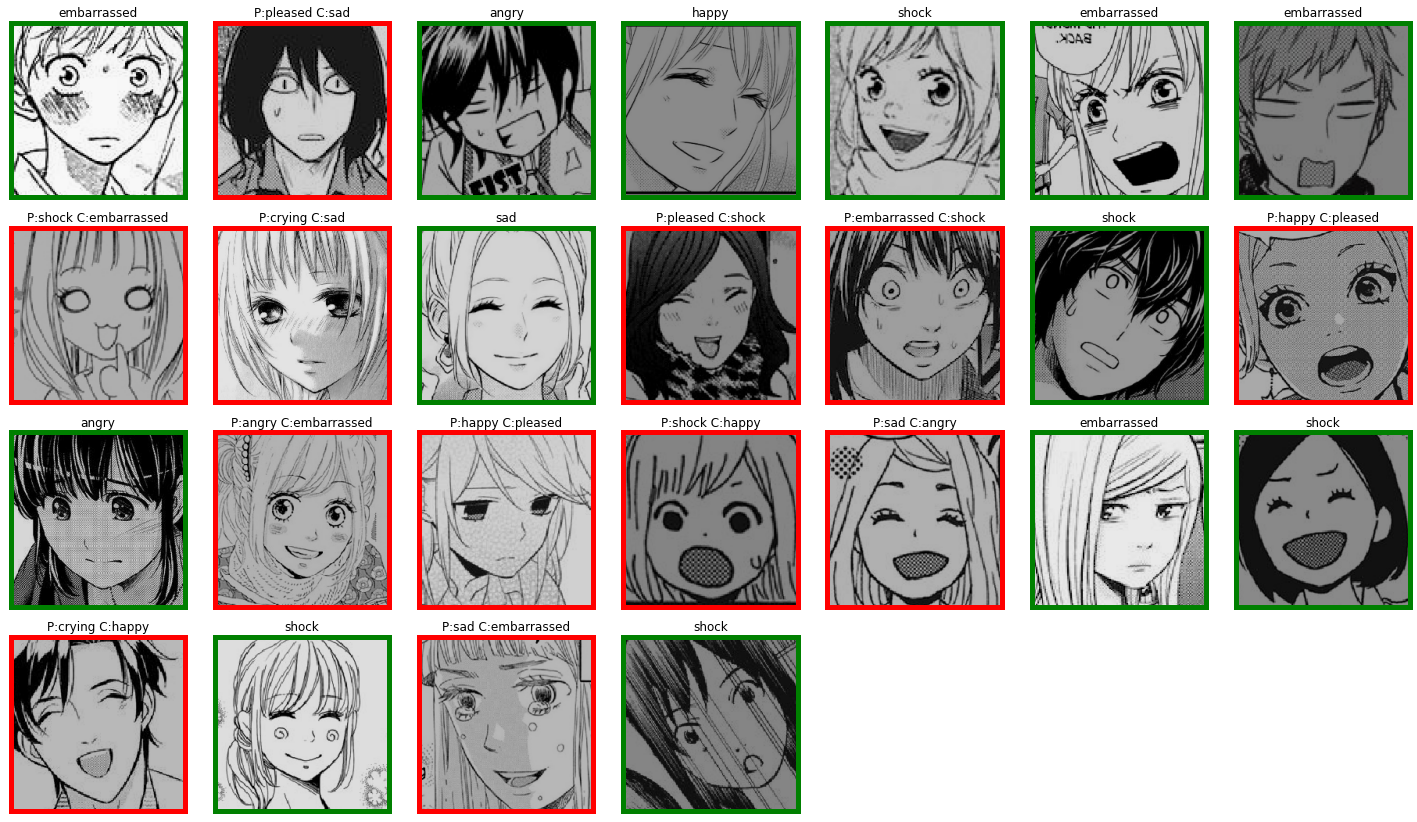

In [45]:
fig = plt.figure(1, (20, 20))

k = 0
for j in range(25):
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if  y_idx2[j] == idx2[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')
            ans  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx2[j])]
        ax.set_title(ans)

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')
            correct  = list(emotion_dict.keys())[list(emotion_dict.values()).index(y_idx2[j])]
            preds  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx2[j])]
        ax.set_title('P:'+preds+" C:"+correct)
    plt.tight_layout()

## Early Stop

In [90]:
model3 = tf.keras.models.Sequential()
#b1
model3.add(layers.Conv2D(64, 1, activation='relu',input_shape=(224, 224, 3)))
model3.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'))
model3.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))


#b2
model3.add(layers.Conv2D(64, 1, strides=2, padding='same', activation='relu'))
model3.add(layers.Conv2D(192, 3, strides=2, padding='same', activation='relu'))
model3.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model3.add(Inception(64, (96, 128), (16, 32), 32))
#model3.add(Inception(128, (128, 192), (32, 96), 64))
model3.add(Inception(128, (128, 192), (32, 96), 64))
model3.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b4
model3.add(Inception(192, (96, 208), (16, 48), 64))
model3.add(Inception(160, (112, 224), (24, 64), 64))
model3.add(Inception(128, (128, 256), (24, 64), 64))
model3.add(Inception(112, (144, 288), (32, 64), 64))
model3.add(Inception(256, (160, 320), (32, 128), 128))
model3.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
#model3.add(layers.LeakyReLU())
#model3.add(BatchNormalization())


#b5
model3.add(Inception(256, (160, 320), (32, 128), 128))
#model3.add(Inception(384, (192, 384), (48, 128), 128))
model3.add(Inception(384, (192, 384), (48, 128), 128))
model3.add(layers.GlobalAvgPool2D())
model.add(layers.Dropout(0.4))
model3.add(layers.Flatten())

model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(7, activation='softmax'))


In [91]:
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_517 (Conv2D)         (None, 224, 224, 64)      256       
                                                                 
 conv2d_518 (Conv2D)         (None, 112, 112, 64)      200768    
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_519 (Conv2D)         (None, 28, 28, 64)        4160      
                                                                 
 conv2d_520 (Conv2D)         (None, 14, 14, 192)       110784    
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 7, 7, 192)        0         
 ng2D)                                               

In [92]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [93]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-9,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [94]:
img_generator_flow_train.reset()
history = model3.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100, callbacks=callbacks) 


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.9340 - categorical_accuracy: 0.1967

12/12 [==============================] - 7s 300ms/step - loss: 1.9340 - categorical_accuracy: 0.1967 - val_loss: 1.9106 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 1.9068 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 240ms/step - loss: 1.9068 - categorical_accuracy: 0.2240 - val_loss: 1.9069 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 1.9134 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 230ms/step - loss: 1.9134 - categorical_accuracy: 0.2240 - val_loss: 1.9035 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 1.9079 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 241ms/step - loss: 1.9079 - categorical_accuracy: 0.2240 - val_loss: 1.9063 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 5/100
12/12 [==============================] - ETA: 0s - loss: 1.8962 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8962 - categorical_accuracy: 0.2240 - val_loss: 1.8901 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 6/100
12/12 [==============================] - ETA: 0s - loss: 1.9012 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 232ms/step - loss: 1.9012 - categorical_accuracy: 0.2240 - val_loss: 1.9024 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 7/100
12/12 [==============================] - ETA: 0s - loss: 1.8979 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8979 - categorical_accuracy: 0.2240 - val_loss: 1.8909 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 8/100
12/12 [==============================] - ETA: 0s - loss: 1.9011 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 232ms/step - loss: 1.9011 - categorical_accuracy: 0.2240 - val_loss: 1.8955 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 9/100
12/12 [==============================] - ETA: 0s - loss: 1.9023 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 231ms/step - loss: 1.9023 - categorical_accuracy: 0.2240 - val_loss: 1.8943 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 10/100
12/12 [==============================] - ETA: 0s - loss: 1.8998 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 230ms/step - loss: 1.8998 - categorical_accuracy: 0.2240 - val_loss: 1.8989 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 11/100
12/12 [==============================] - ETA: 0s - loss: 1.9007 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 235ms/step - loss: 1.9007 - categorical_accuracy: 0.2240 - val_loss: 1.8877 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 12/100
12/12 [==============================] - ETA: 0s - loss: 1.8945 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8945 - categorical_accuracy: 0.2240 - val_loss: 1.8919 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 13/100
12/12 [==============================] - ETA: 0s - loss: 1.8954 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8954 - categorical_accuracy: 0.2240 - val_loss: 1.8911 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 14/100
12/12 [==============================] - ETA: 0s - loss: 1.8986 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 231ms/step - loss: 1.8986 - categorical_accuracy: 0.2240 - val_loss: 1.8969 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 15/100
12/12 [==============================] - ETA: 0s - loss: 1.9025 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 233ms/step - loss: 1.9025 - categorical_accuracy: 0.2240 - val_loss: 1.8992 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 16/100
12/12 [==============================] - ETA: 0s - loss: 1.9006 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 228ms/step - loss: 1.9006 - categorical_accuracy: 0.2240 - val_loss: 1.8898 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 17/100
12/12 [==============================] - ETA: 0s - loss: 1.8856 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8856 - categorical_accuracy: 0.2240 - val_loss: 1.8979 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 18/100
12/12 [==============================] - ETA: 0s - loss: 1.8866 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 229ms/step - loss: 1.8866 - categorical_accuracy: 0.2240 - val_loss: 1.8934 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 19/100
12/12 [==============================] - ETA: 0s - loss: 1.8978 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 248ms/step - loss: 1.8978 - categorical_accuracy: 0.2240 - val_loss: 1.8989 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 20/100
12/12 [==============================] - ETA: 0s - loss: 1.8848 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 234ms/step - loss: 1.8848 - categorical_accuracy: 0.2240 - val_loss: 1.8887 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 21/100
12/12 [==============================] - ETA: 0s - loss: 1.8956 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 232ms/step - loss: 1.8956 - categorical_accuracy: 0.2240 - val_loss: 1.8792 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 22/100
12/12 [==============================] - ETA: 0s - loss: 1.8718 - categorical_accuracy: 0.2240

12/12 [==============================] - 3s 230ms/step - loss: 1.8718 - categorical_accuracy: 0.2240 - val_loss: 1.8825 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 23/100
12/12 [==============================] - ETA: 0s - loss: 1.8562 - categorical_accuracy: 0.2295

12/12 [==============================] - 3s 233ms/step - loss: 1.8562 - categorical_accuracy: 0.2295 - val_loss: 1.8797 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 24/100
12/12 [==============================] - ETA: 0s - loss: 1.8502 - categorical_accuracy: 0.2623

12/12 [==============================] - 3s 228ms/step - loss: 1.8502 - categorical_accuracy: 0.2623 - val_loss: 1.8774 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 25/100
12/12 [==============================] - ETA: 0s - loss: 1.8457 - categorical_accuracy: 0.2596

12/12 [==============================] - 3s 230ms/step - loss: 1.8457 - categorical_accuracy: 0.2596 - val_loss: 1.8629 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 26/100
12/12 [==============================] - ETA: 0s - loss: 1.8379 - categorical_accuracy: 0.2650

12/12 [==============================] - 3s 227ms/step - loss: 1.8379 - categorical_accuracy: 0.2650 - val_loss: 1.8941 - val_categorical_accuracy: 0.2360 - lr: 1.0000e-04
Epoch 27/100
12/12 [==============================] - ETA: 0s - loss: 1.8437 - categorical_accuracy: 0.2350

12/12 [==============================] - 3s 226ms/step - loss: 1.8437 - categorical_accuracy: 0.2350 - val_loss: 1.8728 - val_categorical_accuracy: 0.2584 - lr: 1.0000e-04
Epoch 28/100
12/12 [==============================] - ETA: 0s - loss: 1.8224 - categorical_accuracy: 0.2377

12/12 [==============================] - 3s 229ms/step - loss: 1.8224 - categorical_accuracy: 0.2377 - val_loss: 1.9059 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 29/100
12/12 [==============================] - ETA: 0s - loss: 1.8044 - categorical_accuracy: 0.2650

12/12 [==============================] - 3s 228ms/step - loss: 1.8044 - categorical_accuracy: 0.2650 - val_loss: 1.8258 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 30/100
12/12 [==============================] - ETA: 0s - loss: 1.7606 - categorical_accuracy: 0.2787

12/12 [==============================] - 3s 227ms/step - loss: 1.7606 - categorical_accuracy: 0.2787 - val_loss: 1.8439 - val_categorical_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 1.7996 - categorical_accuracy: 0.2842

12/12 [==============================] - 3s 227ms/step - loss: 1.7996 - categorical_accuracy: 0.2842 - val_loss: 1.9614 - val_categorical_accuracy: 0.2697 - lr: 1.0000e-04
Epoch 32/100
12/12 [==============================] - ETA: 0s - loss: 1.8027 - categorical_accuracy: 0.2787

12/12 [==============================] - 3s 226ms/step - loss: 1.8027 - categorical_accuracy: 0.2787 - val_loss: 1.9015 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 33/100
12/12 [==============================] - ETA: 0s - loss: 1.7986 - categorical_accuracy: 0.2541

12/12 [==============================] - 3s 230ms/step - loss: 1.7986 - categorical_accuracy: 0.2541 - val_loss: 1.8593 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 34/100
12/12 [==============================] - ETA: 0s - loss: 1.7147 - categorical_accuracy: 0.2951

12/12 [==============================] - 3s 229ms/step - loss: 1.7147 - categorical_accuracy: 0.2951 - val_loss: 1.8232 - val_categorical_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 35/100
12/12 [==============================] - ETA: 0s - loss: 1.6750 - categorical_accuracy: 0.3251

12/12 [==============================] - 3s 227ms/step - loss: 1.6750 - categorical_accuracy: 0.3251 - val_loss: 1.9050 - val_categorical_accuracy: 0.2022 - lr: 1.0000e-04
Epoch 36/100
12/12 [==============================] - ETA: 0s - loss: 1.8030 - categorical_accuracy: 0.2705

12/12 [==============================] - 3s 236ms/step - loss: 1.8030 - categorical_accuracy: 0.2705 - val_loss: 1.9194 - val_categorical_accuracy: 0.1685 - lr: 1.0000e-04
Epoch 37/100
12/12 [==============================] - ETA: 0s - loss: 1.8069 - categorical_accuracy: 0.2678

12/12 [==============================] - 3s 230ms/step - loss: 1.8069 - categorical_accuracy: 0.2678 - val_loss: 1.9827 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 38/100
12/12 [==============================] - ETA: 0s - loss: 1.7130 - categorical_accuracy: 0.2787

12/12 [==============================] - 3s 227ms/step - loss: 1.7130 - categorical_accuracy: 0.2787 - val_loss: 1.8231 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 39/100
12/12 [==============================] - ETA: 0s - loss: 1.7181 - categorical_accuracy: 0.2650

12/12 [==============================] - 3s 234ms/step - loss: 1.7181 - categorical_accuracy: 0.2650 - val_loss: 1.7982 - val_categorical_accuracy: 0.3371 - lr: 1.0000e-04
Epoch 40/100
12/12 [==============================] - ETA: 0s - loss: 1.6697 - categorical_accuracy: 0.3169

12/12 [==============================] - 3s 228ms/step - loss: 1.6697 - categorical_accuracy: 0.3169 - val_loss: 1.8153 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 41/100
12/12 [==============================] - ETA: 0s - loss: 1.6388 - categorical_accuracy: 0.3579

12/12 [==============================] - 3s 227ms/step - loss: 1.6388 - categorical_accuracy: 0.3579 - val_loss: 1.7805 - val_categorical_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 42/100
12/12 [==============================] - ETA: 0s - loss: 1.5439 - categorical_accuracy: 0.3907

12/12 [==============================] - 3s 227ms/step - loss: 1.5439 - categorical_accuracy: 0.3907 - val_loss: 1.7969 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 43/100
12/12 [==============================] - ETA: 0s - loss: 1.4858 - categorical_accuracy: 0.3852

12/12 [==============================] - 3s 229ms/step - loss: 1.4858 - categorical_accuracy: 0.3852 - val_loss: 2.0018 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 44/100
12/12 [==============================] - ETA: 0s - loss: 1.4081 - categorical_accuracy: 0.4098

12/12 [==============================] - 3s 230ms/step - loss: 1.4081 - categorical_accuracy: 0.4098 - val_loss: 1.9004 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 45/100
12/12 [==============================] - ETA: 0s - loss: 1.4279 - categorical_accuracy: 0.3798

12/12 [==============================] - 3s 228ms/step - loss: 1.4279 - categorical_accuracy: 0.3798 - val_loss: 1.8589 - val_categorical_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 46/100
12/12 [==============================] - ETA: 0s - loss: 1.5445 - categorical_accuracy: 0.3716

12/12 [==============================] - 3s 239ms/step - loss: 1.5445 - categorical_accuracy: 0.3716 - val_loss: 1.9137 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 47/100
12/12 [==============================] - ETA: 0s - loss: 1.5846 - categorical_accuracy: 0.3415

12/12 [==============================] - 3s 231ms/step - loss: 1.5846 - categorical_accuracy: 0.3415 - val_loss: 1.7263 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 48/100
12/12 [==============================] - ETA: 0s - loss: 1.4118 - categorical_accuracy: 0.4290

12/12 [==============================] - 3s 230ms/step - loss: 1.4118 - categorical_accuracy: 0.4290 - val_loss: 1.6956 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 49/100
12/12 [==============================] - ETA: 0s - loss: 1.2725 - categorical_accuracy: 0.4563

12/12 [==============================] - 3s 233ms/step - loss: 1.2725 - categorical_accuracy: 0.4563 - val_loss: 2.0757 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 50/100
12/12 [==============================] - ETA: 0s - loss: 1.2097 - categorical_accuracy: 0.4481

12/12 [==============================] - 3s 244ms/step - loss: 1.2097 - categorical_accuracy: 0.4481 - val_loss: 2.2296 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04
Epoch 51/100
12/12 [==============================] - ETA: 0s - loss: 1.1476 - categorical_accuracy: 0.5055

12/12 [==============================] - 3s 233ms/step - loss: 1.1476 - categorical_accuracy: 0.5055 - val_loss: 2.1661 - val_categorical_accuracy: 0.2697 - lr: 1.0000e-04
Epoch 52/100
12/12 [==============================] - ETA: 0s - loss: 1.0743 - categorical_accuracy: 0.5710

12/12 [==============================] - 3s 233ms/step - loss: 1.0743 - categorical_accuracy: 0.5710 - val_loss: 2.0412 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 53/100
12/12 [==============================] - ETA: 0s - loss: 1.0331 - categorical_accuracy: 0.5628

12/12 [==============================] - 3s 242ms/step - loss: 1.0331 - categorical_accuracy: 0.5628 - val_loss: 2.1720 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 54/100
12/12 [==============================] - ETA: 0s - loss: 1.1705 - categorical_accuracy: 0.4836

12/12 [==============================] - 3s 230ms/step - loss: 1.1705 - categorical_accuracy: 0.4836 - val_loss: 1.9440 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 55/100
12/12 [==============================] - ETA: 0s - loss: 1.1122 - categorical_accuracy: 0.5219

12/12 [==============================] - 3s 240ms/step - loss: 1.1122 - categorical_accuracy: 0.5219 - val_loss: 1.8306 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 56/100
12/12 [==============================] - ETA: 0s - loss: 0.9904 - categorical_accuracy: 0.5984

12/12 [==============================] - 3s 229ms/step - loss: 0.9904 - categorical_accuracy: 0.5984 - val_loss: 2.3615 - val_categorical_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 57/100
12/12 [==============================] - ETA: 0s - loss: 0.8244 - categorical_accuracy: 0.6475

12/12 [==============================] - 3s 230ms/step - loss: 0.8244 - categorical_accuracy: 0.6475 - val_loss: 2.5878 - val_categorical_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 58/100
12/12 [==============================] - ETA: 0s - loss: 0.8929 - categorical_accuracy: 0.6339

12/12 [==============================] - 3s 231ms/step - loss: 0.8929 - categorical_accuracy: 0.6339 - val_loss: 2.3684 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 59/100
12/12 [==============================] - ETA: 0s - loss: 0.9441 - categorical_accuracy: 0.6120

12/12 [==============================] - 3s 230ms/step - loss: 0.9441 - categorical_accuracy: 0.6120 - val_loss: 2.1727 - val_categorical_accuracy: 0.2584 - lr: 1.0000e-04
Epoch 60/100
12/12 [==============================] - ETA: 0s - loss: 0.7775 - categorical_accuracy: 0.7295

12/12 [==============================] - 3s 230ms/step - loss: 0.7775 - categorical_accuracy: 0.7295 - val_loss: 2.5066 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 61/100
12/12 [==============================] - ETA: 0s - loss: 0.8564 - categorical_accuracy: 0.6448

12/12 [==============================] - 3s 229ms/step - loss: 0.8564 - categorical_accuracy: 0.6448 - val_loss: 2.8248 - val_categorical_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 62/100
12/12 [==============================] - ETA: 0s - loss: 0.7807 - categorical_accuracy: 0.7049

12/12 [==============================] - 3s 233ms/step - loss: 0.7807 - categorical_accuracy: 0.7049 - val_loss: 2.9006 - val_categorical_accuracy: 0.2697 - lr: 1.0000e-04
Epoch 63/100
12/12 [==============================] - ETA: 0s - loss: 0.6594 - categorical_accuracy: 0.7377

12/12 [==============================] - 3s 231ms/step - loss: 0.6594 - categorical_accuracy: 0.7377 - val_loss: 2.9032 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 64/100
12/12 [==============================] - ETA: 0s - loss: 0.6152 - categorical_accuracy: 0.7268

12/12 [==============================] - 3s 240ms/step - loss: 0.6152 - categorical_accuracy: 0.7268 - val_loss: 2.6917 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 65/100
12/12 [==============================] - ETA: 0s - loss: 0.6872 - categorical_accuracy: 0.7377

12/12 [==============================] - 3s 230ms/step - loss: 0.6872 - categorical_accuracy: 0.7377 - val_loss: 3.9289 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 66/100
12/12 [==============================] - ETA: 0s - loss: 0.7303 - categorical_accuracy: 0.6913

12/12 [==============================] - 3s 230ms/step - loss: 0.7303 - categorical_accuracy: 0.6913 - val_loss: 2.5086 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 67/100
12/12 [==============================] - ETA: 0s - loss: 0.6559 - categorical_accuracy: 0.7350

12/12 [==============================] - 3s 231ms/step - loss: 0.6559 - categorical_accuracy: 0.7350 - val_loss: 3.3865 - val_categorical_accuracy: 0.3708 - lr: 1.0000e-04
Epoch 68/100
12/12 [==============================] - ETA: 0s - loss: 0.4872 - categorical_accuracy: 0.8361

12/12 [==============================] - 3s 231ms/step - loss: 0.4872 - categorical_accuracy: 0.8361 - val_loss: 3.2635 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 69/100
12/12 [==============================] - ETA: 0s - loss: 0.4709 - categorical_accuracy: 0.8060

12/12 [==============================] - 3s 228ms/step - loss: 0.4709 - categorical_accuracy: 0.8060 - val_loss: 4.4069 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 70/100
12/12 [==============================] - ETA: 0s - loss: 0.4402 - categorical_accuracy: 0.8197

12/12 [==============================] - 3s 228ms/step - loss: 0.4402 - categorical_accuracy: 0.8197 - val_loss: 4.0418 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 71/100
12/12 [==============================] - ETA: 0s - loss: 0.3554 - categorical_accuracy: 0.8607

12/12 [==============================] - 3s 229ms/step - loss: 0.3554 - categorical_accuracy: 0.8607 - val_loss: 4.6346 - val_categorical_accuracy: 0.2697 - lr: 1.0000e-04
Epoch 72/100
12/12 [==============================] - ETA: 0s - loss: 0.3364 - categorical_accuracy: 0.8770

12/12 [==============================] - 3s 228ms/step - loss: 0.3364 - categorical_accuracy: 0.8770 - val_loss: 5.1352 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 73/100
12/12 [==============================] - ETA: 0s - loss: 0.3254 - categorical_accuracy: 0.8770

12/12 [==============================] - 3s 240ms/step - loss: 0.3254 - categorical_accuracy: 0.8770 - val_loss: 4.5114 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 74/100
12/12 [==============================] - ETA: 0s - loss: 0.2546 - categorical_accuracy: 0.8962

12/12 [==============================] - 3s 231ms/step - loss: 0.2546 - categorical_accuracy: 0.8962 - val_loss: 4.5996 - val_categorical_accuracy: 0.3371 - lr: 1.0000e-04
Epoch 75/100
12/12 [==============================] - ETA: 0s - loss: 0.1971 - categorical_accuracy: 0.9454

12/12 [==============================] - 3s 230ms/step - loss: 0.1971 - categorical_accuracy: 0.9454 - val_loss: 4.9261 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 76/100
12/12 [==============================] - ETA: 0s - loss: 0.3236 - categorical_accuracy: 0.8743

12/12 [==============================] - 3s 228ms/step - loss: 0.3236 - categorical_accuracy: 0.8743 - val_loss: 5.1545 - val_categorical_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 77/100
12/12 [==============================] - ETA: 0s - loss: 0.6766 - categorical_accuracy: 0.7432

12/12 [==============================] - 3s 229ms/step - loss: 0.6766 - categorical_accuracy: 0.7432 - val_loss: 3.6697 - val_categorical_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 78/100
12/12 [==============================] - ETA: 0s - loss: 0.3369 - categorical_accuracy: 0.8934

12/12 [==============================] - 3s 226ms/step - loss: 0.3369 - categorical_accuracy: 0.8934 - val_loss: 3.2337 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 79/100
12/12 [==============================] - ETA: 0s - loss: 0.2034 - categorical_accuracy: 0.9590

12/12 [==============================] - 3s 229ms/step - loss: 0.2034 - categorical_accuracy: 0.9590 - val_loss: 4.3349 - val_categorical_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 80/100
12/12 [==============================] - ETA: 0s - loss: 0.1280 - categorical_accuracy: 0.9781

12/12 [==============================] - 3s 229ms/step - loss: 0.1280 - categorical_accuracy: 0.9781 - val_loss: 5.7204 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 81/100
12/12 [==============================] - ETA: 0s - loss: 0.1135 - categorical_accuracy: 0.9645

12/12 [==============================] - 3s 228ms/step - loss: 0.1135 - categorical_accuracy: 0.9645 - val_loss: 5.8948 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 82/100
12/12 [==============================] - ETA: 0s - loss: 0.5357 - categorical_accuracy: 0.8279

12/12 [==============================] - 3s 229ms/step - loss: 0.5357 - categorical_accuracy: 0.8279 - val_loss: 5.9414 - val_categorical_accuracy: 0.2360 - lr: 1.0000e-04
Epoch 83/100
12/12 [==============================] - ETA: 0s - loss: 0.3701 - categorical_accuracy: 0.8579

12/12 [==============================] - 3s 228ms/step - loss: 0.3701 - categorical_accuracy: 0.8579 - val_loss: 3.3829 - val_categorical_accuracy: 0.3258 - lr: 1.0000e-04
Epoch 84/100
12/12 [==============================] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9262

12/12 [==============================] - 3s 226ms/step - loss: 0.2313 - categorical_accuracy: 0.9262 - val_loss: 4.9912 - val_categorical_accuracy: 0.2697 - lr: 1.0000e-04
Epoch 85/100
12/12 [==============================] - ETA: 0s - loss: 0.1192 - categorical_accuracy: 0.9617

12/12 [==============================] - 3s 227ms/step - loss: 0.1192 - categorical_accuracy: 0.9617 - val_loss: 5.0215 - val_categorical_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 86/100
12/12 [==============================] - ETA: 0s - loss: 0.0912 - categorical_accuracy: 0.9754

12/12 [==============================] - 3s 230ms/step - loss: 0.0912 - categorical_accuracy: 0.9754 - val_loss: 6.0187 - val_categorical_accuracy: 0.3371 - lr: 1.0000e-04
Epoch 87/100
12/12 [==============================] - ETA: 0s - loss: 0.0670 - categorical_accuracy: 0.9781

12/12 [==============================] - 3s 228ms/step - loss: 0.0670 - categorical_accuracy: 0.9781 - val_loss: 6.9337 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 88/100
12/12 [==============================] - ETA: 0s - loss: 0.0889 - categorical_accuracy: 0.9672

12/12 [==============================] - 3s 233ms/step - loss: 0.0889 - categorical_accuracy: 0.9672 - val_loss: 6.4079 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 89/100
12/12 [==============================] - ETA: 0s - loss: 0.1864 - categorical_accuracy: 0.9481

12/12 [==============================] - 3s 230ms/step - loss: 0.1864 - categorical_accuracy: 0.9481 - val_loss: 7.0903 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 90/100
12/12 [==============================] - ETA: 0s - loss: 0.2660 - categorical_accuracy: 0.9016

12/12 [==============================] - 3s 231ms/step - loss: 0.2660 - categorical_accuracy: 0.9016 - val_loss: 6.0574 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 91/100
12/12 [==============================] - ETA: 0s - loss: 0.3062 - categorical_accuracy: 0.8989

12/12 [==============================] - 3s 230ms/step - loss: 0.3062 - categorical_accuracy: 0.8989 - val_loss: 5.1308 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 92/100
12/12 [==============================] - ETA: 0s - loss: 0.2080 - categorical_accuracy: 0.9071

12/12 [==============================] - 3s 227ms/step - loss: 0.2080 - categorical_accuracy: 0.9071 - val_loss: 4.6039 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 93/100
12/12 [==============================] - ETA: 0s - loss: 0.1535 - categorical_accuracy: 0.9508

12/12 [==============================] - 3s 226ms/step - loss: 0.1535 - categorical_accuracy: 0.9508 - val_loss: 4.9422 - val_categorical_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 94/100
12/12 [==============================] - ETA: 0s - loss: 0.1081 - categorical_accuracy: 0.9754

12/12 [==============================] - 3s 226ms/step - loss: 0.1081 - categorical_accuracy: 0.9754 - val_loss: 6.1911 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 95/100
12/12 [==============================] - ETA: 0s - loss: 0.0534 - categorical_accuracy: 0.9863

12/12 [==============================] - 3s 229ms/step - loss: 0.0534 - categorical_accuracy: 0.9863 - val_loss: 5.4728 - val_categorical_accuracy: 0.3146 - lr: 1.0000e-04
Epoch 96/100
12/12 [==============================] - ETA: 0s - loss: 0.0225 - categorical_accuracy: 1.0000

12/12 [==============================] - 3s 232ms/step - loss: 0.0225 - categorical_accuracy: 1.0000 - val_loss: 6.1708 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 97/100
12/12 [==============================] - ETA: 0s - loss: 0.0200 - categorical_accuracy: 0.9973

12/12 [==============================] - 3s 233ms/step - loss: 0.0200 - categorical_accuracy: 0.9973 - val_loss: 7.1595 - val_categorical_accuracy: 0.2809 - lr: 1.0000e-04
Epoch 98/100
12/12 [==============================] - ETA: 0s - loss: 0.0424 - categorical_accuracy: 0.9945

12/12 [==============================] - 3s 231ms/step - loss: 0.0424 - categorical_accuracy: 0.9945 - val_loss: 6.6551 - val_categorical_accuracy: 0.2921 - lr: 1.0000e-04
Epoch 99/100
12/12 [==============================] - ETA: 0s - loss: 0.0355 - categorical_accuracy: 0.9918

12/12 [==============================] - 3s 230ms/step - loss: 0.0355 - categorical_accuracy: 0.9918 - val_loss: 8.6847 - val_categorical_accuracy: 0.3034 - lr: 1.0000e-04
Epoch 100/100
12/12 [==============================] - ETA: 0s - loss: 0.3078 - categorical_accuracy: 0.8852

12/12 [==============================] - 3s 230ms/step - loss: 0.3078 - categorical_accuracy: 0.8852 - val_loss: 8.6035 - val_categorical_accuracy: 0.2247 - lr: 1.0000e-04


In [95]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

0.2793258437514305

In [96]:
max(history.history["val_categorical_accuracy"])

0.37078651785850525

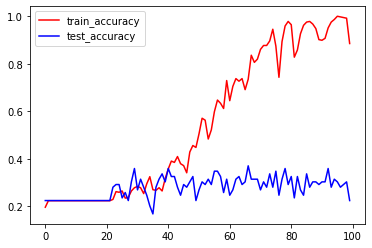

In [97]:
plt.plot(model3.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model3.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [98]:
x3,y3 = img_generator_flow_valid.next()
preds3 = model3.predict(x3)
idx3 = np.argmax(preds3, axis = 1)
y_idx3 = np.argmax(y3, axis = 1)

1/1 [==============================] - 0s 476ms/step


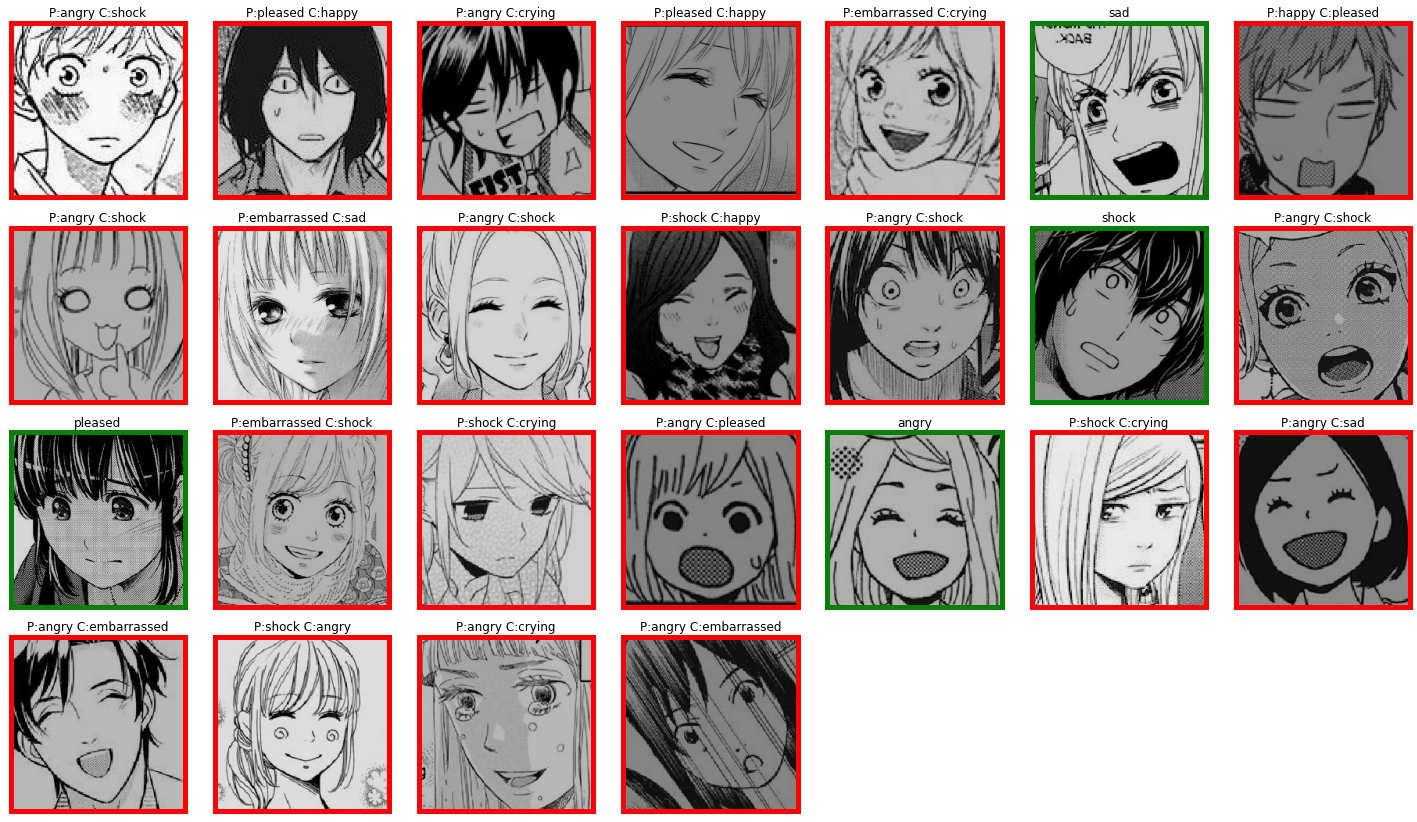

In [99]:
fig = plt.figure(1, (20, 20))

k = 0
for j in range(25):
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if  y_idx3[j] == idx3[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')
            ans  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx3[j])]
        ax.set_title(ans)

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')
            correct  = list(emotion_dict.keys())[list(emotion_dict.values()).index(y_idx3[j])]
            preds  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx3[j])]
        ax.set_title('P:'+preds+" C:"+correct)
    plt.tight_layout()

## L2

In [60]:
model4 = tf.keras.models.Sequential()
#b1
#model.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model4.add(layers.Conv2D(64, 7, strides=2,padding='same' , activation='relu', input_shape=(224, 224, 3), kernel_regularizer= tf.keras.regularizers.l2(l=0.01)))
#model4.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'))
model4.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model4.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.01)))
model4.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.01)))
model4.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model4.add(Inception(64, (96, 128), (16, 32), 32))
model4.add(Inception(128, (128, 192), (32, 96), 64))
model4.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model4.add(Inception(192, (96, 208), (16, 48), 64))
model4.add(Inception(160, (112, 224), (24, 64), 64))
model4.add(Inception(128, (128, 256), (24, 64), 64))
model4.add(Inception(112, (144, 288), (32, 64), 64))
model4.add(Inception(256, (160, 320), (32, 128), 128))
model4.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b5
model4.add(Inception(256, (160, 320), (32, 128), 128))
model4.add(Inception(384, (192, 384), (48, 128), 128))
model4.add(layers.GlobalAvgPool2D())
model4.add(layers.Dropout(0.4))
model4.add(layers.Flatten())

#model4.add(layers.Dense(64, activation='relu'))
#model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(7, activation='softmax'))


In [61]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_298 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_299 (Conv2D)         (None, 56, 56, 64)        36928     
                                                                 
 conv2d_300 (Conv2D)         (None, 56, 56, 192)       110784    
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 28, 28, 192)      0         
 g2D)                                                            
                                                                 
 inception_47 (Inception)    (None, 28, 28, 256)      

In [62]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [64]:
img_generator_flow_train.reset()
history = model4.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 


Epoch 1/100
12/12 [==============================] - 5s 293ms/step - loss: 3.5551 - categorical_accuracy: 0.2131 - val_loss: 3.4779 - val_categorical_accuracy: 0.2247
Epoch 2/100
12/12 [==============================] - 3s 227ms/step - loss: 3.4329 - categorical_accuracy: 0.2240 - val_loss: 3.3709 - val_categorical_accuracy: 0.2247
Epoch 3/100
12/12 [==============================] - 3s 235ms/step - loss: 3.3369 - categorical_accuracy: 0.2322 - val_loss: 3.2814 - val_categorical_accuracy: 0.1910
Epoch 4/100
12/12 [==============================] - 3s 231ms/step - loss: 3.2613 - categorical_accuracy: 0.2158 - val_loss: 3.1989 - val_categorical_accuracy: 0.2247
Epoch 5/100
12/12 [==============================] - 3s 227ms/step - loss: 3.1784 - categorical_accuracy: 0.2213 - val_loss: 3.1348 - val_categorical_accuracy: 0.2247
Epoch 6/100
12/12 [==============================] - 3s 227ms/step - loss: 3.1053 - categorical_accuracy: 0.2268 - val_loss: 3.0568 - val_categorical_accuracy: 0.224

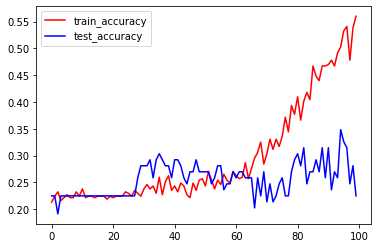

In [65]:
plt.plot(model4.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model4.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [67]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

0.29699453502893447

In [68]:
max(history.history["val_categorical_accuracy"])

0.5601093173027039

In [66]:
x4,y4 = img_generator_flow_valid.next()
preds4 = model4.predict(x4)
idx4 = np.argmax(preds4, axis = 1)
y_idx4 = np.argmax(y4, axis = 1)

1/1 [==============================] - 0s 485ms/step


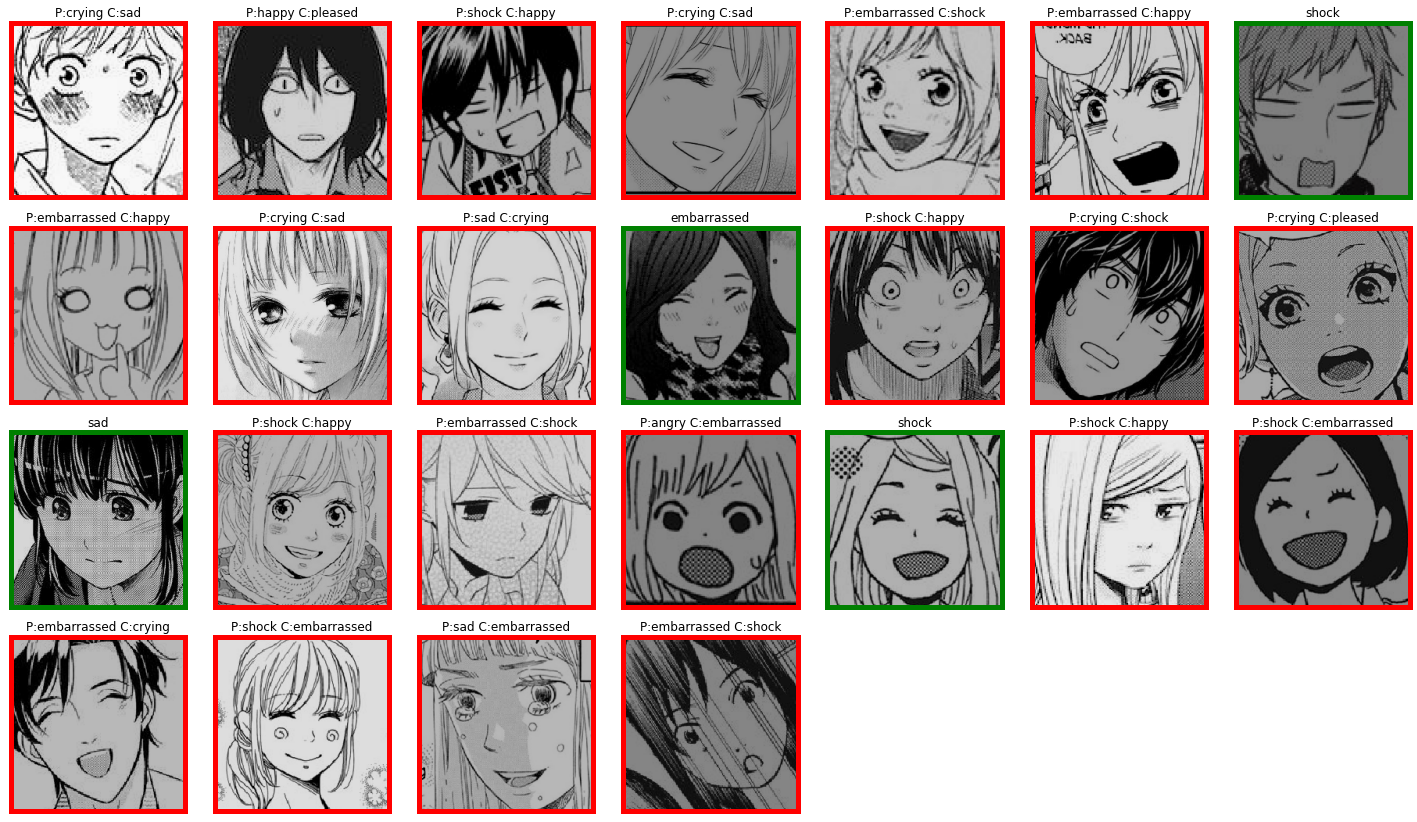

In [69]:
fig = plt.figure(1, (20, 20))

k = 0
for j in range(25):
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if  y_idx4[j] == idx4[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')
            ans  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx4[j])]
        ax.set_title(ans)

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')
            correct  = list(emotion_dict.keys())[list(emotion_dict.values()).index(y_idx4[j])]
            preds  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx4[j])]
        ax.set_title('P:'+preds+" C:"+correct)
    plt.tight_layout()

## dense

In [79]:
model5 = tf.keras.models.Sequential()
#b1
#model5.add(layers.Conv2D(64, 7, activation='relu',input_shape=(224, 224, 3)))
model5.add(layers.Conv2D(64, 7, strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model5.add(layers.MaxPool2D(pool_size=3, strides=2,padding='same'))

#b2
model5.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
model5.add(layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'))
model5.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b3
model5.add(Inception(64, (96, 128), (16, 32), 32))
model5.add(Inception(64, (96, 128), (16, 32), 32))
model5.add(Inception(128, (128, 192), (32, 96), 64))
model5.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

#b4
model5.add(Inception(192, (96, 208), (16, 48), 64))
model5.add(Inception(160, (112, 224), (24, 64), 64))
model5.add(Inception(128, (128, 256), (24, 64), 64))
model5.add(Inception(112, (144, 288), (32, 64), 64))
model5.add(Inception(256, (160, 320), (32, 128), 128))
model5.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


#b5
model5.add(Inception(256, (160, 320), (32, 128), 128))
model5.add(Inception(256, (160, 320), (32, 128), 128))
model5.add(Inception(384, (192, 384), (48, 128), 128))
model5.add(layers.GlobalAvgPool2D())
model5.add(layers.Dropout(0.4))
model5.add(layers.Flatten())

#model.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(7, activation='softmax'))


In [80]:
model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_448 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_449 (Conv2D)         (None, 56, 56, 64)        36928     
                                                                 
 conv2d_450 (Conv2D)         (None, 56, 56, 192)       110784    
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 28, 28, 192)      0         
 ng2D)                                                           
                                                                 
 inception_67 (Inception)    (None, 28, 28, 256)      

In [82]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [83]:
img_generator_flow_train.reset()
history = model5.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, epochs=100) 


Epoch 1/100
12/12 [==============================] - 8s 306ms/step - loss: 1.9322 - categorical_accuracy: 0.1913 - val_loss: 1.9135 - val_categorical_accuracy: 0.1910
Epoch 2/100
12/12 [==============================] - 3s 231ms/step - loss: 1.9189 - categorical_accuracy: 0.1885 - val_loss: 1.9041 - val_categorical_accuracy: 0.2247
Epoch 3/100
12/12 [==============================] - 3s 240ms/step - loss: 1.9125 - categorical_accuracy: 0.1749 - val_loss: 1.9009 - val_categorical_accuracy: 0.2247
Epoch 4/100
12/12 [==============================] - 3s 229ms/step - loss: 1.9037 - categorical_accuracy: 0.1967 - val_loss: 1.8968 - val_categorical_accuracy: 0.2247
Epoch 5/100
12/12 [==============================] - 3s 228ms/step - loss: 1.9044 - categorical_accuracy: 0.2240 - val_loss: 1.9038 - val_categorical_accuracy: 0.2247
Epoch 6/100
12/12 [==============================] - 3s 230ms/step - loss: 1.9099 - categorical_accuracy: 0.2268 - val_loss: 1.9068 - val_categorical_accuracy: 0.224

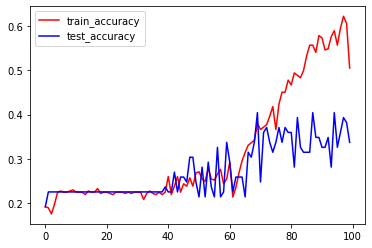

In [84]:
plt.plot(model5.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model5.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [86]:
max(history.history["val_categorical_accuracy"])

0.40449437499046326

In [87]:
sum(history.history["val_categorical_accuracy"])/len(history.history["val_categorical_accuracy"])

0.272359553873539

In [88]:
x5,y5 = img_generator_flow_valid.next()
preds5 = model5.predict(x5)
idx5 = np.argmax(preds5, axis = 1)
y_idx5 = np.argmax(y5, axis = 1)

1/1 [==============================] - 1s 585ms/step


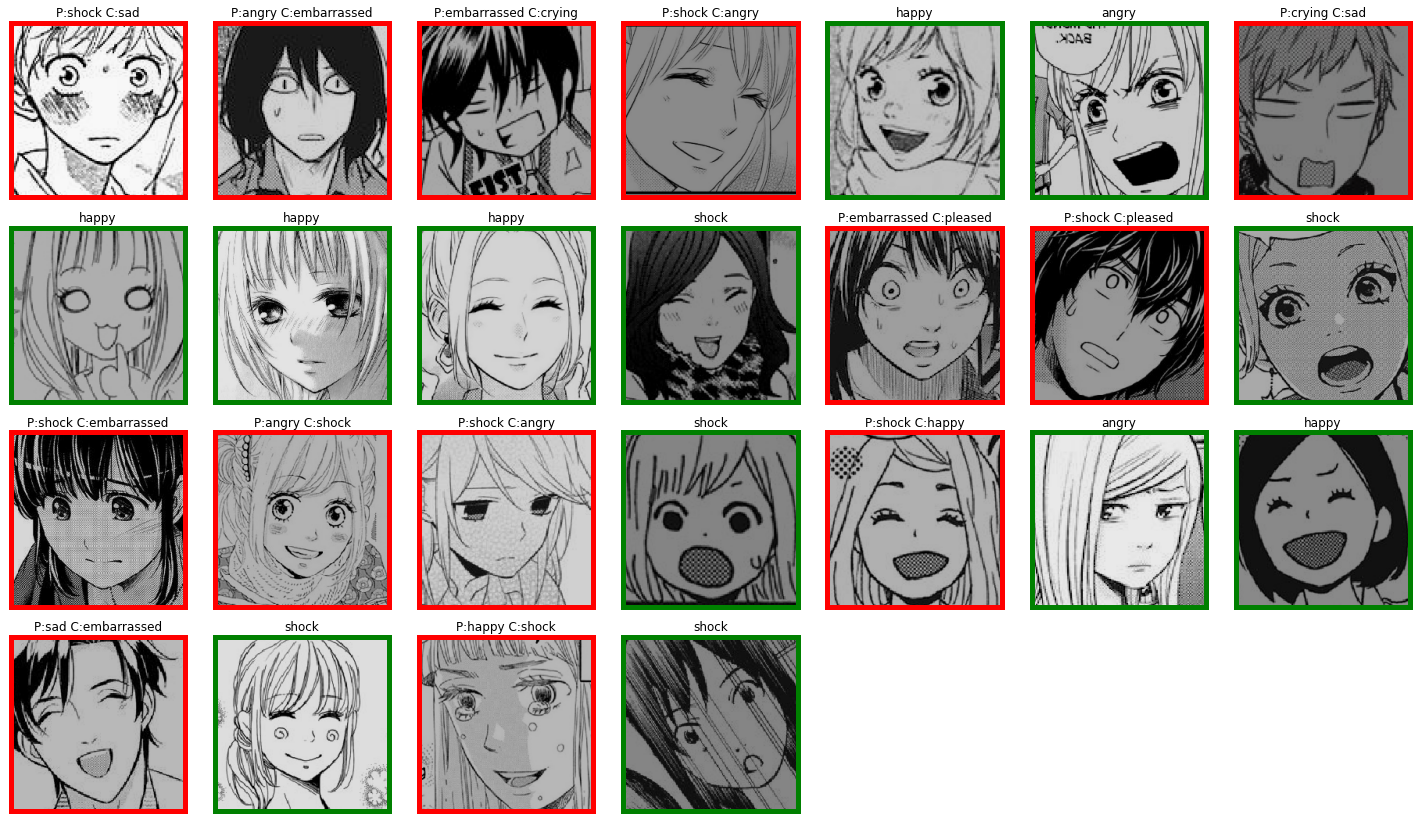

In [89]:
fig = plt.figure(1, (20, 20))

k = 0
for j in range(25):
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if  y_idx5[j] == idx5[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')
            ans  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx5[j])]
        ax.set_title(ans)

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')
            correct  = list(emotion_dict.keys())[list(emotion_dict.values()).index(y_idx5[j])]
            preds  = list(emotion_dict.keys())[list(emotion_dict.values()).index(idx5[j])]
        ax.set_title('P:'+preds+" C:"+correct)
    plt.tight_layout()